# Experiment  0: ToM Overall Model Performance


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch

In [3]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [4]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [5]:
def visualize_map(campus,
                  path=None,
                  goal_nodes=None,
                  ax=None):
    """
    Visualize the campus map, plus optional trajectory, start, waypoint, and goal nodes.
    
    Arguments:
      campus         an object with:
                        - campus.G           : a networkx graph
                        - campus.node_coords : dict[node] -> (x, y) coordinates
                        - campus.buildings   : a GeoDataFrame of building footprints (or None)
      path           list of node‐IDs, the agent’s trajectory to draw (in order)
      start_nodes    list of node‐IDs to mark as start(s)
      waypoint       single node‐ID to mark as an intermediate waypoint
      goal_nodes     list of node‐IDs to mark as goal(s)
      ax             optional matplotlib Axes onto which to draw
      
    Returns:
      fig, ax        the figure & axis
    """
    # 1) draw the base map
    if ax is None:
        fig, ax = ox.plot_graph(campus.G,
                                figsize=(15,15),
                                node_size=5,
                                edge_color="#999999",
                                show=False,
                                close=False)
    else:
        fig = ax.figure
        ox.plot_graph(campus.G,
                      ax=ax,
                      node_size=5,
                      edge_color="#999999",
                      show=False)
    
    # 2) overlay buildings if you have them
    if getattr(campus, "buildings", None) is not None:
        campus.buildings.plot(ax=ax,
                              color="#bbbbbb",
                              alpha=0.7,
                              edgecolor="#444444")
    
    # 3) draw the agent’s path
    if path is not None and len(path) > 1:
        coords = [campus.node_coords[n] for n in path]
        xs, ys = zip(*coords)
        ax.plot(xs, ys,
                linestyle='-',
                linewidth=3.0,
                color='lightblue',
                alpha=0.8,
                zorder=3,
                label="Trajectory")
        # and mark the actual visited nodes
        ax.scatter(xs, ys,
                   c='C0',
                   s=30,
                   zorder=4)
    
    # 6) mark goal nodes
    if goal_nodes:
        goal_coords = [campus.node_coords[n] for n in goal_nodes]
        xs, ys = zip(*goal_coords)
        ax.scatter(xs, ys,
                   c="yellow",
                   s=160,
                   marker="*",
                   zorder=5,
                   label="Goal")
    
    # 7) finalize
    ax.legend(loc="upper right")
    ax.set_title("UCSD Campus Environment")
    ax.set_axis_off()
    fig.tight_layout()
    return fig, ax

In [6]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color


## Steps  
1. Create the UCSD campus world
2. Create n agents each with a specific distribution over the goals
3. Run m epsiodes where each agent chooses a goal and performs a single path to that goal
4. Use this data as training set

## Step 1: Create the Map

In [7]:
# Create a run manager
# run_manager = RunManager('visuals')
# run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Loading graph from ucsd_campus.graphml...
Environment loaded with 3151 nodes and 8746 edges


## Step 2: Create N Agents

In [8]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [9]:
""" Already created agents and saved as pkl
# Create n agents
agents = []
n = 100
for i in range(n):
    agents.append(AgentFactory.create_agent("shortest"))
    agents[i].id = i

n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
    agent.environment = campus

# Save the agents 
import pickle

# suppose `agents` is your list of Agent instances
with open('agents.pkl', 'wb') as f:
    pickle.dump(agents, f)

"""

' Already created agents and saved as pkl\n# Create n agents\nagents = []\nn = 100\nfor i in range(n):\n    agents.append(AgentFactory.create_agent("shortest"))\n    agents[i].id = i\n\nn_goals = len(goals)\nag_alpha = np.random.normal(1, 0.2, size=n_goals)\n\nfor agent in agents: # Set each agent\'s goal distribution\n    agent.goal_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]\n    agent.environment = campus\n\n# Save the agents \nimport pickle\n\n# suppose `agents` is your list of Agent instances\nwith open(\'agents.pkl\', \'wb\') as f:\n    pickle.dump(agents, f)\n\n'

In [10]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

## Step 3: Perform Episodes and Data Collection

In [11]:
import json

In [12]:
"""Already ran once. Data is saved in /data

path_data = {}
goal_data = {}
m = 100
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    path_data[episode] = episode_path_data
    goal_data[episode] = episode_goal_data

with open("./data/path_data.json", "w") as file:
    json.dump(path_data, file, indent=4)

with open("./data/goal_data.json", "w") as file:
    json.dump(goal_data, file, indent=4)
    """


'Already ran once. Data is saved in /data\n\npath_data = {}\ngoal_data = {}\nm = 100\nfor episode in range(m):\n    new_episode(agents)\n    episode_path_data = {}\n    episode_goal_data = {}\n    for agent in agents:\n        agent.plan_path()\n        episode_path_data[agent.id] = agent.path\n        episode_goal_data[agent.id] = agent.goal_node\n    # Save the data from each episode\n    path_data[episode] = episode_path_data\n    goal_data[episode] = episode_goal_data\n\nwith open("./data/path_data.json", "w") as file:\n    json.dump(path_data, file, indent=4)\n\nwith open("./data/goal_data.json", "w") as file:\n    json.dump(goal_data, file, indent=4)\n    '

### Load existing data

In [13]:
import json, pickle

with open("./../data/1k/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./../data/1k/goal_data.json", 'r') as file:
    goal_data = json.load(file)

with open('./../data/1k/agents.pkl', 'rb') as f:
    agents = pickle.load(f)

/tmp/ipykernel_2671586/1732508900.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  agents = pickle.load(f)


In [14]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [15]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 4: Fit the Models
There should again be a dict of dict for posteriors. The first key will be for the episode, the second key will be the agent, and the value of this will be a list of dicts for the posteriors. 

## Load all the posteriors from Arshia!

In [16]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
### Pickle files   

import pickle, json

# BToM posteriors
with open('./../data/Arshia_experiment_0/btom_posteriors.pkl', 'rb') as f:
    posteriors_data = pickle.load(f)

# Extended BToM posteriors
with open('./../data/Arshia_experiment_0/ebtom_posteriors.pkl', 'rb') as f:
    ext_posteriors_data = pickle.load(f)

# GRU posteriors
with open('./../data/Arshia_experiment_0/gru_posteriors.pkl', 'rb') as f:
    gru_posteriors = pickle.load(f)

# LSTM posteriors
with open('./../data/Arshia_experiment_0/lstm_posteriors.pkl', 'rb') as f:
    lstm_posteriors = pickle.load(f)

# ToMNet posteriors
with open('./../data/Arshia_experiment_0/tomnet_posteriors.pkl', 'rb') as f:
    tomnet_posteriors = pickle.load(f)


# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: [0, 1, 2]
GRU episodes: [0, 1, 2]
ToMNet episodes: [0, 1, 2]
LSTM episodes: [0, 1, 2]
Ext BTOM episodes: [0, 1, 2]


### SOTA: Our Model

In [24]:
# load tomnet_causal_final_scores from TomNet_Causal_Scores.json
import json
with open('./../data/Arshia_experiment_0/TomNet_Causal_Scores.json', 'r') as f:
    tomnet_causal_final_scores = json.load(f)

## Step 5: Visualizing Performance for Experiment 0  
We want to visualize the average brier score across all agents for all epsiodes. That is, calculate the brier score for every path and then take the average. Plot this as a line.

In [25]:
from real_world_src.utils.metrics import brier_along_path, accuracy_along_path

In [26]:
########### Latest.  
# Robust scores for all methods: match path and posterior lengths to avoid IndexError

# BToM Scores
scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in posteriors_data[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# Extended BToM Scores
ext_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in ext_posteriors_data[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = ext_posteriors_data[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        ext_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# ToMNet Scores (only for test agents)
tomnet_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids or agent.id not in tomnet_posteriors[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = tomnet_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        tomnet_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# LSTM Scores
lstm_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids or agent.id not in lstm_posteriors[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = lstm_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        lstm_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

# GRU Scores
gru_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        if agent.id not in test_agent_ids or agent.id not in gru_posteriors[episode]:
            continue
        path = path_data[episode][agent.id]
        posteriors = gru_posteriors[episode][agent.id]
        min_len = min(len(path), len(posteriors))
        if min_len == 0:
            continue
        gru_scores.append(brier_along_path(
            path[:min_len],
            goal_data[episode][agent.id],
            posteriors[:min_len],
            goals
        ))

In [27]:
# # tomnet causal scores
# tomnet_causal_scores = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in tomnet_causal_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = tomnet_causal_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         tomnet_causal_scores.append(brier_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

In [71]:
# ############ Latest 1st Aug Accuracy #############
# # Robust accuracy for all methods: match path and posterior lengths to avoid IndexError

# # BToM Accuracy
# btom_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in posteriors_data[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = posteriors_data[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         btom_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # Extended BToM Accuracy
# ext_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in ext_posteriors_data[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = ext_posteriors_data[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         ext_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # ToMNet Accuracy (only for test agents)
# tomnet_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in tomnet_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = tomnet_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         tomnet_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # LSTM Accuracy
# lstm_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in lstm_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = lstm_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         lstm_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

# # GRU Accuracy
# gru_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in gru_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = gru_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         gru_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

In [72]:
# # tomnet causal accuracy
# tomnet_causal_acc = []
# for episode in range(len(goal_data)):
#     for agent in agents:
#         if agent.id not in test_agent_ids or agent.id not in tomnet_causal_posteriors[episode]:
#             continue
#         path = path_data[episode][agent.id]
#         posteriors = tomnet_causal_posteriors[episode][agent.id]
#         min_len = min(len(path), len(posteriors))
#         if min_len == 0:
#             continue
#         tomnet_causal_acc.append(accuracy_along_path(
#             path[:min_len],
#             goal_data[episode][agent.id],
#             posteriors[:min_len],
#             goals
#         ))

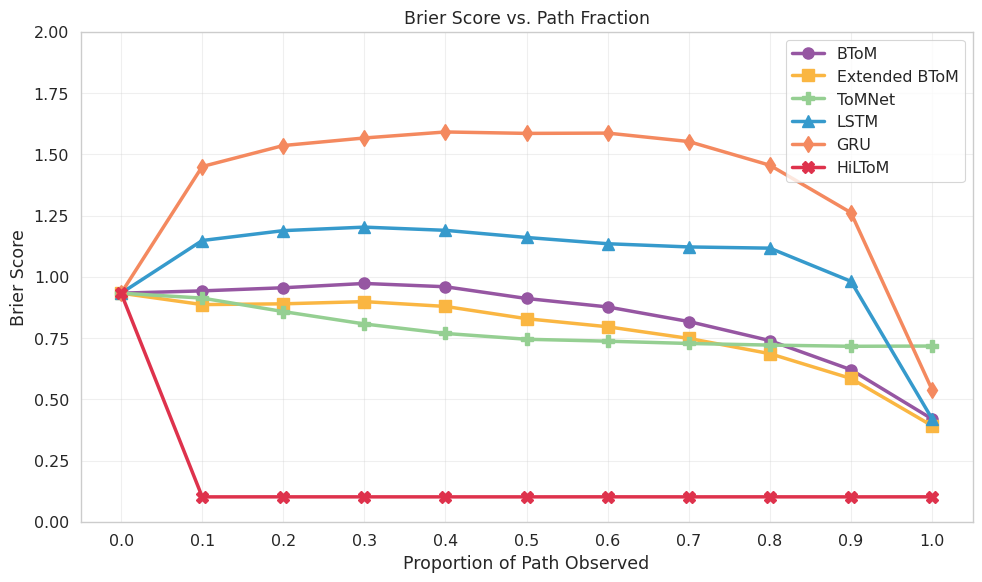

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(scores)  # shape (N, 11)
ext_arr  = np.array(ext_scores)
tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_causal_arr = np.array(tomnet_causal_final_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

linewidth_val = 2.5
markersize_val = 8

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, "#9656a2" , marker='o', markersize=markersize_val, linewidth=linewidth_val, label='BToM')
plt.plot(props, mean_ext,  "#fab642", marker='s', markersize=markersize_val, linewidth=linewidth_val, label='Extended BToM')
plt.plot(props, mean_tomnet, "#95cf92", marker='P', markersize=markersize_val, linewidth=linewidth_val, label='ToMNet')
plt.plot(props, mean_lstm, "#369acc", marker='^', markersize=markersize_val, linewidth=linewidth_val, label='LSTM')
plt.plot(props, mean_gru, "#f4895f", marker='d', markersize=markersize_val, linewidth=linewidth_val, label='GRU')
plt.plot(props, mean_tomnet_causal, "#de324c", marker='X', markersize=markersize_val, linewidth=linewidth_val, label='HiToM')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('exp_0_brier_score.png', dpi=900, bbox_inches='tight', 
           facecolor='white', edgecolor='none', format='png')

plt.show()


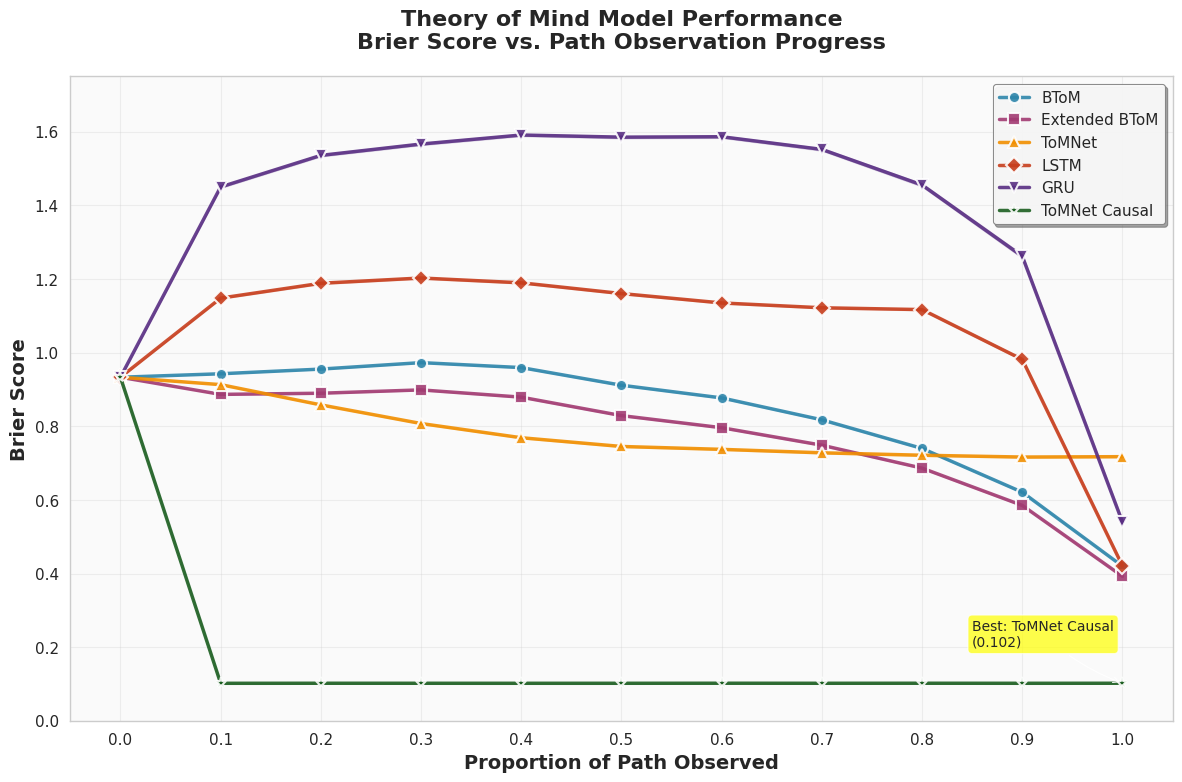


SUMMARY STATISTICS - FINAL BRIER SCORES
1. ToMNet Causal  : 0.1023
2. Extended BToM  : 0.3927
3. BToM           : 0.4202
4. LSTM           : 0.4211
5. GRU            : 0.5399
6. ToMNet         : 0.7176


In [31]:
# Enhanced Brier Score Visualization with Seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

# Set the aesthetic style
plt.style.use('default')
sns.set_theme(style="whitegrid", palette="husl")
sns.set_context("paper", font_scale=1.3)

# Create a more sophisticated color palette
colors = {
    'BToM': '#2E86AB',
    'Extended BToM': '#A23B72', 
    'ToMNet': '#F18F01',
    'LSTM': '#C73E1D',
    'GRU': '#592E83',
    'ToMNet Causal': '#1B5E20'
}

# Prepare data arrays
arr = np.array(scores)
ext_arr = np.array(ext_scores)
tomnet_arr = np.array(tomnet_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_causal_arr = np.array(tomnet_causal_final_scores)
props = np.linspace(0, 1, arr.shape[1])

# Compute means and standard errors
def compute_stats(data):
    mean = data.mean(axis=0)
    sem = stats.sem(data, axis=0)  # Standard error of the mean
    return mean, sem

mean_base, sem_base = compute_stats(arr)
mean_ext, sem_ext = compute_stats(ext_arr)
mean_tomnet, sem_tomnet = compute_stats(tomnet_arr)
mean_lstm, sem_lstm = compute_stats(lstm_arr)
mean_gru, sem_gru = compute_stats(gru_arr)
mean_tomnet_causal, sem_tomnet_causal = compute_stats(tomnet_causal_arr)

# Create the enhanced plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot lines with confidence intervals
methods = [
    ('BToM', mean_base, sem_base, 'o'),
    ('Extended BToM', mean_ext, sem_ext, 's'),
    ('ToMNet', mean_tomnet, sem_tomnet, '^'),
    ('LSTM', mean_lstm, sem_lstm, 'D'),
    ('GRU', mean_gru, sem_gru, 'v'),
    ('ToMNet Causal', mean_tomnet_causal, sem_tomnet_causal, '*')
]

for method, mean_vals, sem_vals, marker in methods:
    # Plot the main line
    ax.plot(props, mean_vals, 
           marker=marker, 
           linewidth=2.5, 
           markersize=8,
           label=method,
           color=colors[method],
           markerfacecolor=colors[method],
           markeredgecolor='white',
           markeredgewidth=1.5,
           alpha=0.9)
    
    # Add confidence interval
    ax.fill_between(props, 
                   mean_vals - sem_vals, 
                   mean_vals + sem_vals, 
                   alpha=0.2, 
                   color=colors[method])

# Customize the plot
ax.set_xlabel('Proportion of Path Observed', fontsize=14, fontweight='bold')
ax.set_ylabel('Brier Score', fontsize=14, fontweight='bold')
ax.set_title('Theory of Mind Model Performance\nBrier Score vs. Path Observation Progress', 
            fontsize=16, fontweight='bold', pad=20)

# Set axis limits and ticks
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0, max(mean_base.max(), mean_ext.max(), mean_tomnet.max(), 
                  mean_lstm.max(), mean_gru.max(), mean_tomnet_causal.max()) * 1.1)

# Customize ticks
ax.set_xticks(props)
ax.set_xticklabels([f'{p:.1f}' for p in props])
ax.tick_params(axis='both', which='major', labelsize=11)

# Enhance grid
ax.grid(True, alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)

# Create a more sophisticated legend
legend = ax.legend(loc='upper right', 
                  frameon=True, 
                  fancybox=True, 
                  shadow=True,
                  ncol=1,
                  fontsize=11,
                  bbox_to_anchor=(1.0, 1.0))
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('gray')

# Add subtle background color
ax.set_facecolor('#fafafa')

# Adjust layout
plt.tight_layout()

# Add annotations for best performing model at different points
best_final = min([(mean_tomnet_causal[-1], 'ToMNet Causal'),
                  (mean_base[-1], 'BToM'),
                  (mean_ext[-1], 'Extended BToM'),
                  (mean_tomnet[-1], 'ToMNet'),
                  (mean_lstm[-1], 'LSTM'),
                  (mean_gru[-1], 'GRU')])

ax.annotate(f'Best: {best_final[1]}\n({best_final[0]:.3f})',
           xy=(1.0, best_final[0]),
           xytext=(0.85, best_final[0] + 0.1),
           fontsize=10,
           bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1'))

plt.show()

# Create a summary statistics table
print("\n" + "="*80)
print("SUMMARY STATISTICS - FINAL BRIER SCORES")
print("="*80)

final_scores = {
    'BToM': mean_base[-1],
    'Extended BToM': mean_ext[-1], 
    'ToMNet': mean_tomnet[-1],
    'LSTM': mean_lstm[-1],
    'GRU': mean_gru[-1],
    'ToMNet Causal': mean_tomnet_causal[-1]
}

# Sort by performance (lower is better for Brier score)
sorted_scores = sorted(final_scores.items(), key=lambda x: x[1])

for i, (method, score) in enumerate(sorted_scores, 1):
    print(f"{i}. {method:<15}: {score:.4f}")

print("="*80)

In [51]:
# Compute Brier score and accuracy at 25th, 50th, 75th, and 95th percentiles of path completion
import numpy as np

percentiles = [0.25, 0.5, 0.75, 0.95]
percentile_indices = lambda arr: [max(0, min(len(arr)-1, int(np.ceil(p*len(arr))-1))) for p in percentiles]

# Helper to extract values at percentiles for a list of per-step scores

def extract_percentile_values(score_list):
    vals = [[] for _ in percentiles]
    for arr in score_list:
        idxs = percentile_indices(arr)
        for i, idx in enumerate(idxs):
            vals[i].append(arr[idx])
    return vals

# Brier Score percentiles
btom_brier_percentiles = extract_percentile_values(scores)
ext_btom_brier_percentiles = extract_percentile_values(ext_scores)
tomnet_brier_percentiles = extract_percentile_values(tomnet_scores)
lstm_brier_percentiles = extract_percentile_values(lstm_scores)
gru_brier_percentiles = extract_percentile_values(gru_scores)
tomnet_causal_brier_percentiles = extract_percentile_values(tomnet_causal_final_scores)

# Accuracy percentiles
# btom_acc_percentiles = extract_percentile_values(btom_acc)
# ext_btom_acc_percentiles = extract_percentile_values(ext_acc)
# tomnet_acc_percentiles = extract_percentile_values(tomnet_acc)
# lstm_acc_percentiles = extract_percentile_values(lstm_acc)
# gru_acc_percentiles = extract_percentile_values(gru_acc)

# Example: print mean Brier score at each percentile for BToM
for i, p in enumerate(percentiles):
    print(f"BToM mean Brier score at {int(p*100)}th percentile: {np.mean(btom_brier_percentiles[i]):.4f}")

# Example: print mean accuracy at each percentile for BToM
# for i, p in enumerate(percentiles):
    # print(f"BToM mean accuracy at {int(p*100)}th percentile: {np.mean(btom_acc_percentiles[i]):.4f}")

# Print mean Brier score and accuracy at 25th, 50th, 75th, and 95th percentiles for all models
model_names = [
    ("BToM", btom_brier_percentiles),
    ("Extended BToM", ext_btom_brier_percentiles),
    ("ToMNet", tomnet_brier_percentiles),
    ("LSTM", lstm_brier_percentiles),
    ("GRU", gru_brier_percentiles),
    ("ToMNet Causal", tomnet_causal_brier_percentiles)
]

for name, brier_p in model_names:
    print(f"\n{name}:")
    for i, p in enumerate(percentiles):
        print(f"  Mean Brier score at {int(p*100)}th percentile: {np.mean(brier_p[i]):.4f}")
    # for i, p in enumerate(percentiles):
        # print(f"  Mean accuracy at {int(p*100)}th percentile: {np.mean(acc_p[i]):.4f}")

BToM mean Brier score at 25th percentile: 0.9555
BToM mean Brier score at 50th percentile: 0.9117
BToM mean Brier score at 75th percentile: 0.7400
BToM mean Brier score at 95th percentile: 0.4202

BToM:
  Mean Brier score at 25th percentile: 0.9555
  Mean Brier score at 50th percentile: 0.9117
  Mean Brier score at 75th percentile: 0.7400
  Mean Brier score at 95th percentile: 0.4202

Extended BToM:
  Mean Brier score at 25th percentile: 0.8899
  Mean Brier score at 50th percentile: 0.8292
  Mean Brier score at 75th percentile: 0.6865
  Mean Brier score at 95th percentile: 0.3927

ToMNet:
  Mean Brier score at 25th percentile: 0.8583
  Mean Brier score at 50th percentile: 0.7453
  Mean Brier score at 75th percentile: 0.7215
  Mean Brier score at 95th percentile: 0.7176

LSTM:
  Mean Brier score at 25th percentile: 1.1886
  Mean Brier score at 50th percentile: 1.1606
  Mean Brier score at 75th percentile: 1.1171
  Mean Brier score at 95th percentile: 0.4211

GRU:
  Mean Brier score at 2

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `scores` is your (n_trajectories × n_fractions) array:
arr = np.array(btom_acc)  # shape (N, 11)
ext_arr  = np.array(ext_acc)
tom_arr = np.array(tomnet_acc)
lstm_arr = np.array(lstm_acc)
gru_arr = np.array(gru_acc)
tomnet_causal_arr = np.array(tomnet_causal_acc)
props = np.linspace(0, 1, arr.shape[1])

# Compute mean
mean_base = arr.mean(axis=0)
mean_ext  = ext_arr.mean(axis=0)
mean_tom  = tom_arr.mean(axis=0)
mean_lstm  = lstm_arr.mean(axis=0)
mean_gru  = gru_arr.mean(axis=0)
mean_tomnet_causal = tomnet_causal_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_tom, '-o', label='ToMNet')
plt.plot(props, mean_lstm, '-o', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')
plt.plot(props, mean_tomnet_causal, '-x', label='ToMNet Causal')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'tomnet_acc' is not defined

1. Use geospatial coordinates instead of IDs for nodes
2. Consider an embedding for the nodes --  we are using an embedding for the nodes
3. Consider multi head loss
4. Consider other loss functions for the distribution
5. The character net has a strange input where the multiple past trajs are concatenated

# Load existing pickle and json files to plot

1. Run from Step 0 till Step 4 (Models) 
2. Run Step 5
3. Run the following cells

In [ ]:
n_test = int(0.2 * len(agents))
test_agent_ids = [agent.id for agent in agents[-n_test:]]

In [ ]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
### Pickle files   

import pickle, json

# Example: Load BToM posteriors (adjust path as needed)
with open('./btom_posteriors.pkl', 'rb') as f:
    posteriors_data = pickle.load(f)

# Example: Load GRU posteriors
with open('./gru_posteriors.pkl', 'rb') as f:
    gru_posteriors = pickle.load(f)

with open('./ebtom_posteriors.pkl', 'rb') as f:
    ext_posteriors_data = pickle.load(f)

# Example: Load ToMNet posteriors (can be .pkl or .json)
#with open('./../data/1k/tomnet_posteriors.pkl', 'r') as f:
 #   tomnet_posteriors = pickle.load(f)

# If you have .json files instead, use:
with open('./tomnet_posteriors.pkl', 'rb') as f:
    tomnet_posteriors = pickle.load(f)

with open('./lstm_posteriors.pkl', 'rb') as f:
    lstm_posteriors = pickle.load(f)

# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: [0, 1, 2]
GRU episodes: [0, 1, 2]
ToMNet episodes: [0, 1, 2]
LSTM episodes: [0, 1, 2]
Ext BTOM episodes: [0, 1, 2]


In [ ]:
# --- Load Precomputed Posteriors for Analysis/Plotting ---
### JSON files

import pickle, json

# Example: Load BToM posteriors (adjust path as needed)
with open('./btom_posteriors.json', 'r') as f:
    posteriors_data = json.load(f)

# Example: Load GRU posteriors
with open('./gru_posteriors.json', 'r') as f:
    gru_posteriors = json.load(f)

with open('./ebtom_posteriors.json', 'r') as f:
    ext_posteriors_data = json.load(f)

# Example: Load ToMNet posteriors (can be .pkl or .json)
#with open('./../data/1k/tomnet_posteriors.pkl', 'r') as f:
 #   tomnet_posteriors = pickle.load(f)

# If you have .json files instead, use:
with open('./tomnet_posteriors.json', 'r') as f:
    tomnet_posteriors = json.load(f)

with open('./lstm_posteriors.json', 'r') as f:
    lstm_posteriors = json.load(f)

# Now you can use these loaded posteriors in your analysis/plotting code as before.
# For example, to compute Brier scores or accuracy, just use the loaded posteriors_data, gru_posteriors, tomnet_posteriors, etc.

# Example: print keys to verify loading
print('BToM episodes:', list(posteriors_data.keys())[:3])
print('GRU episodes:', list(gru_posteriors.keys())[:3])
print('ToMNet episodes:', list(tomnet_posteriors.keys())[:3])
print('LSTM episodes:', list(lstm_posteriors.keys())[:3])
print('Ext BTOM episodes:', list(ext_posteriors_data.keys())[:3])

BToM episodes: ['0', '1', '2']
GRU episodes: ['0', '1', '2']
ToMNet episodes: ['0', '1', '2']
LSTM episodes: ['0', '1', '2']
Ext BTOM episodes: ['0', '1', '2']


wandb: Currently logged in as: rah-m (rebot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


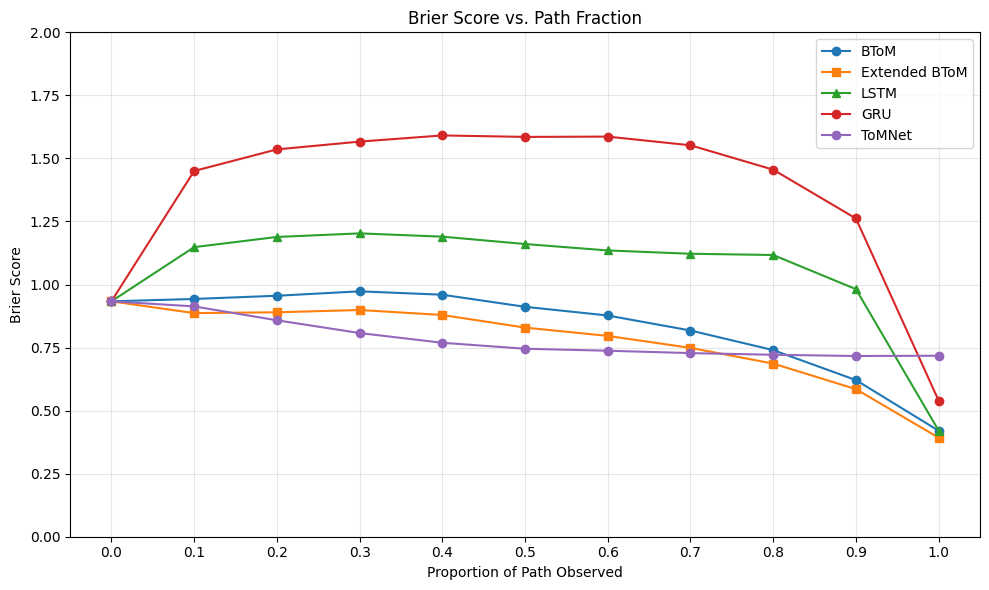

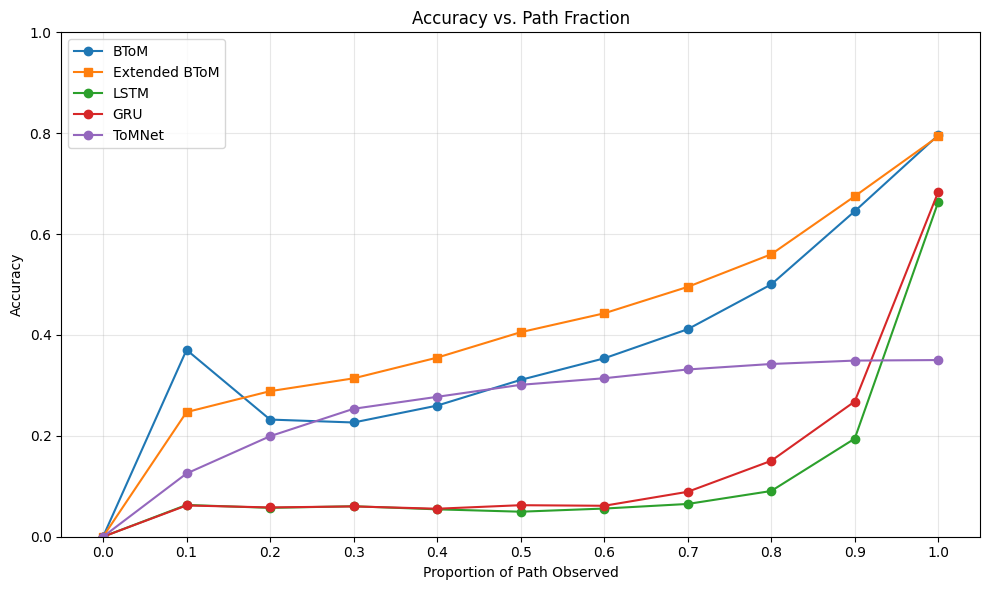

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [36]:
# --- Log Brier Score and Accuracy Plots to Weights & Biases (wandb) ---
import wandb

# Initialize wandb run (set your project name)
wandb.init(project="baseline_experiment0", name="posteriors_analysis")

# Plot and log Brier Score
import numpy as np
import matplotlib.pyplot as plt

arr = np.array(scores)
ext_arr = np.array(ext_scores)
lstm_arr = np.array(lstm_scores)
gru_arr = np.array(gru_scores)
tomnet_arr = np.array(tomnet_scores)  
props = np.linspace(0, 1, arr.shape[1])

mean_base = arr.mean(axis=0)
mean_ext = ext_arr.mean(axis=0)
mean_lstm = lstm_arr.mean(axis=0)
mean_gru = gru_arr.mean(axis=0)
mean_tomnet = tomnet_arr.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base, '-o', label='BToM')
plt.plot(props, mean_ext,  '-s', label='Extended BToM')
plt.plot(props, mean_lstm, '-^', label='LSTM')
plt.plot(props, mean_gru, '-o', label='GRU')
plt.plot(props, mean_tomnet, '-o', label='ToMNet')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 2)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
wandb.log({"Brier Score vs. Path Fraction": wandb.Image(plt)})
plt.show()

# Plot and log Accuracy
arr_acc = np.array(btom_acc)
ext_arr_acc = np.array(ext_acc)
lstm_arr_acc = np.array(lstm_acc)
gru_arr_acc = np.array(gru_acc)
tomnet_arr_acc = np.array(tomnet_acc)

mean_base_acc = arr_acc.mean(axis=0)
mean_ext_acc = ext_arr_acc.mean(axis=0)
mean_lstm_acc = lstm_arr_acc.mean(axis=0)
mean_gru_acc = gru_arr_acc.mean(axis=0)
mean_tomnet_acc = tomnet_arr_acc.mean(axis=0)

plt.figure(figsize=(10,6))
plt.plot(props, mean_base_acc, '-o', label='BToM')
plt.plot(props, mean_ext_acc,  '-s', label='Extended BToM')
plt.plot(props, mean_lstm_acc, '-o', label='LSTM')
plt.plot(props, mean_gru_acc, '-o', label='GRU')
plt.plot(props, mean_tomnet_acc, '-o', label='ToMNet')
plt.xlabel('Proportion of Path Observed')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Path Fraction')
plt.xticks(props)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
wandb.log({"Accuracy vs. Path Fraction": wandb.Image(plt)})
plt.show()

wandb.finish()